In [19]:
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import statistics as stats

In [44]:
# 7개의 주요 통화쌍에 대해 4년간 일간 데이터를 가져온다.
TRADING_INSTRUMENT = 'CADUSD=X'
SYMBOLS = ['AUDUSD=X','GBPUSD=X','CADUSD=X','CHFUSD=X','EURUSD=X','JPYUSD=X','NZDUSD=X']
START_DATE = '2017-01-01'
END_DATE = '2021-01-01'

In [20]:
# 각 통화에 대한 dataSeries
symbols_data = {}
for symbol in SYMBOLS:
    SRC_DATA_FILENAME = symbol + '_data.pkl'
    try:
        data = pd.read_pickle(SRC_DATA_FILENAME)
    except FileNotFoundError:
        data = pdr.DataReader(symbol, 'yahoo', START_DATE, END_DATE)
        data.to_pickle(SRC_DATA_FILENAME)
    symbols_data[symbol] = data

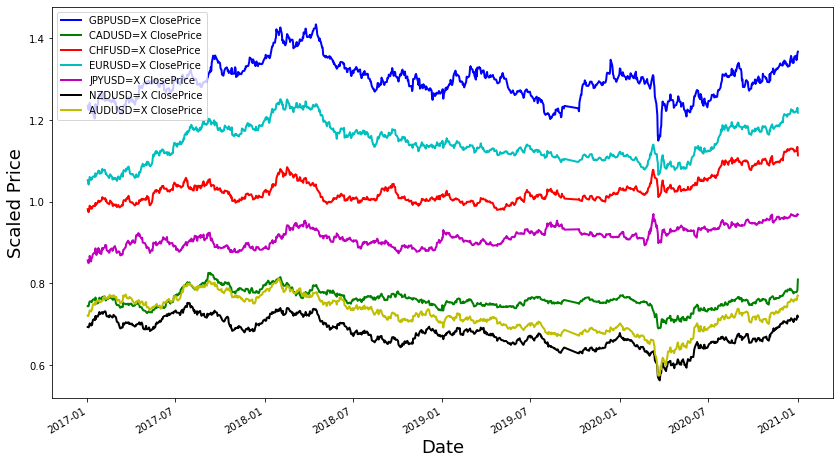

In [39]:
# 통화 쌍 간의 관계를 검사하고자 통화 가격 시각화
cycol = cycle('bgrcmky')

price_data = pd.DataFrame()
for symbol in SYMBOLS:
    multiplier = 1.0
    if symbol == 'JPYUSD=X':
        multiplier = 100.0

    label = symbol + ' ClosePrice'
    price_data = price_data.assign(label=pd.Series(symbols_data[symbol]['Close'] * multiplier, index=symbols_data[symbol].index))
    ax = price_data['label'].plot(color=next(cycol), lw=2., label=label)

# plt.rcParams["figure.figsize"] = (14,8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Scaled Price', fontsize=18)
plt.legend(prop={'size': 10})

plt.show()

# 시그널 파라미터 정의

In [41]:
# 단순이동평균과 단순이동평균으로부터의 가격 편차를 계산하는 데 사용하는 상수/변수
SMA_NUM_PERIODS = 20  # 룩백기간
price_history = {}  # 가격 히스토리

PRICE_DEV_NUM_PRICES = 200 # SMA로부터의 종가 편차를 수집하는 룩백 기간
price_deviation_from_sma = {}  # SMA로부터의 종가 편차의 히스토리

# 수집한 모든 일자의 데이터에 대해 반복 시행
num_days = len(symbols_data[TRADING_INSTRUMENT].index)
correlation_history = {} # 통화 쌍 간의 상관관계 히스토리
delta_projected_actual_history = {} # 예측된 종가 편차와 실제 종가 편차와의 차이의 히스토리

final_delta_projected_history = [] # 거래상품(TRADING_INSTRUMENT)에 대한 최종 예측 종가 편차와 실제 종가 편차와의 차이 히스토리

# 트레이딩 파라미터 정의

In [ ]:
# 전략 트레이드, 포지션과 손익(pnl) 관리를 위한 변수
orders = []             # 매수/매도 주문을 추적하는 변수로 매수 주문은 +1, 매도 주문은 -1, 주문 없으면 0
positions = []          # 포지션을 추적하는 변수로 롱 포지션은 양, 숏 포지션을 음, 포지션이 청산되거나 없으면 0
pnls = []               # 총 손익을 추적하는 변수로 이는 결제 포지션(고정손익)과 미체결 포지션(시장가격으로 평가되는 미결제 포지션 손익)의 합

last_buy_price = 0      # 마지막 매수 거래가 수행된 가ㅕㄱ, 같은 가겨이나 그 주변 가격에서의 과다 거래를 막는데 사용
last_sell_price = 0     # 마지막 매도 거래가 수행된 가격으로, 같은 가격이나 그 주변 가격에서의 과다 거래를 막는데 사용
position = 0            # 트레이딩 전략의 현재 포지션
buy_sum_price_qty = 0   # 마지막으로 포지션이 청산된 후 수행된 모든 매수 거래에 대한 매수 거래 가격과 매수 거래량의 곱의 합
buy_sum_qty = 0         # 마지막으로 포지션이 청산된 후 수행된 모든 매수 거래에 대한 매수 거래량의 합
sell_sum_price_qty = 0  # 마지막으로 포지션이 청산된 후 수행된 모든 매도 거래에 대한 매도 거래 가격과 매도 거래량의 곱의 합
sell_sum_qty = 0        # 마지막으로 포지션이 청산된 후 수행된 모든 매도 거래에 대한 매도 거래량의 합
open_pnl = 0            # 시장 가격으로 평가된 미체결/미실현 손익
closed_pnl = 0          # 이제까지 청산/실현 손익

# 전략 행태/임계값을 정의하는 상수
StatArb_VALUE_FOR_BUY_ENTRY = 0.01     # 그 위로 매수 주문/롱 포지션을 진입하는 Statarb트레이딩 시그널 값
StatArb_VALUE_FOR_SELL_ENTRY = -0.01   # 그 위로 매도 주문/숏 포지션을 진입하는 statarb트레이딩 시그널 값
MIN_PRICE_MOVE_FROM_LAST_TRADE = 0.01  # 트레이딩을 재개하기 위한 마지막 거래로부터의 최소 가격 변화. 이는 같은 가격 또는 주변의 가격에서의 과다 거래를 방지하기 위해
NUM_SHARES_PER_TRADE = 1000000         # 모든 거래에 대해 매수/매도하는 통화 수
MIN_PROFIT_TO_CLOSE = 10               # 포지션을 청산하고 이익을 고정하기 위한 최소 미결제/미실현 손익


# statarb트레이딩 시그널 계량화와 계산

In [42]:
for i in range(0, num_days):
    close_prices = {}

  # 종가 시리즈를 구축하고, 각 종목(symbol)에 대한 SMA와 각 종목의 SMA로부터의 가격 편차를 계산
    for symbol in SYMBOLS:
        close_prices[symbol] = symbols_data[symbol]['Close'].iloc[i]
    if not symbol in price_history.keys():
        price_history[symbol] = []
        price_deviation_from_sma[symbol] = []

    price_history[symbol].append(close_prices[symbol])
    if len(price_history[symbol]) > SMA_NUM_PERIODS:                    # 적어도 SMA_NUM_PERIODS 수만큼 가격 추적
        del (price_history[symbol][0])

    sma = stats.mean(price_history[symbol])                             # 롤링 단순이동평균
    price_deviation_from_sma[symbol].append(close_prices[symbol] - sma) # 평균으로부터 가격 편차
    if len(price_deviation_from_sma[symbol]) > PRICE_DEV_NUM_PRICES:
        del (price_deviation_from_sma[symbol][0])

In [45]:
# 이제 거래 수단과 모든 다른 선도 심벌과의 공분산과 상관계수 구함
# 또한, 예측된 가격 편차를 계산하고, 예측과 실제 가격 편차 간의 델타 발견
projected_dev_from_sma_using = {}
for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # 거래 수단과 그 자체의 관계를 찾을 필요 X
        continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol
    if correlation_label not in correlation_history.keys(): # 히스토리 딕셔너리 내의이 쌍데 해나 첫번째 원소
        correlation_history[correlation_label] = []
        delta_projected_actual_history[correlation_label] = []

    if len(price_deviation_from_sma[symbol]) < 2: # 공분산/상관계수를 계산하는 데 적어도 2개의 관찰값 필요
        correlation_history[correlation_label].append(0)
        delta_projected_actual_history[correlation_label].append(0)
        continue

    corr = np.corrcoef(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
    cov = np.cov(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
    corr_trading_instrument_lead_instrument = corr[0, 1]  # 2시리즈 간의 상관계수 구함
    cov_trading_instrument_lead_instrument = cov[0, 0] / cov[0, 1] # 2 시리즈 간의 공분산을 구함

    correlation_history[correlation_label].append(corr_trading_instrument_lead_instrument)

    # 예측된 거래 수단의 가격 편차는 공분산*선도 symbol의 가겨 편차
    projected_dev_from_sma_using[symbol] = price_deviation_from_sma[symbol][-1] * cov_trading_instrument_lead_instrument

    # 델타가 양이면 시그널은 거래 수단 가격이 오른 것보다 더 오르는 것을 제시
    # 델타가 음이면 시그널은 거래 수단 가격이 내린 것보다 더 하락할 것을 제시
    delta_projected_actual = (projected_dev_from_sma_using[symbol] - price_deviation_from_sma[TRADING_INSTRUMENT][-1])
    delta_projected_actual_history[correlation_label].append(delta_projected_actual)


KeyError: 'CADUSD=X'

In [ ]:
  # weigh predictions from each pair, weight is the correlation between those pairs
  sum_weights = 0 # sum of weights is sum of correlations for each symbol with TRADING_INSTRUMENT
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol
    sum_weights += abs(correlation_history[correlation_label][-1])

  final_delta_projected = 0 # will hold final prediction of price deviation in TRADING_INSTRUMENT, weighing projections from all other symbols.
  close_price = close_prices[TRADING_INSTRUMENT]
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # no need to find relationship between trading instrument and itself
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol

    # weight projection from a symbol by correlation
    final_delta_projected += (abs(correlation_history[correlation_label][-1]) * delta_projected_actual_history[correlation_label][-1])

  # normalize by diving by sum of weights for all pairs
  if sum_weights != 0:
    final_delta_projected /= sum_weights
  else:
    final_delta_projected = 0

  final_delta_projected_history.append(final_delta_projected)

In [40]:
# Plot correlations between TRADING_INSTRUMENT and other currency pairs
correlation_data = pd.DataFrame()
for symbol in SYMBOLS:
  if symbol == TRADING_INSTRUMENT:
    continue

  correlation_label = TRADING_INSTRUMENT + '<-' + symbol
  correlation_data = correlation_data.assign(label=pd.Series(correlation_history[correlation_label], index=symbols_data[symbol].index))
  ax = correlation_data['label'].plot(color=next(cycol), lw=2., label='Correlation ' + correlation_label)

for i in np.arange(-1, 1, 0.25):
  plt.axhline(y=i, lw=0.5, color='k')
plt.legend()
plt.show()

NameError: name 'correlation_history' is not defined